# **Lab of Dimension Reduction from Glorie Metsa Wowo and Lena Monsch**

This notebook is about applying dimension reduction methods to sparse Netflix ratings data. More precisely, the given dataset consists of 1 to 5 star ratings that 610 users gave to around 10 movies each
among 9724 movies. Before being transformed in a more practical format, the original data is loaded together with the needed packages for the analysis following after the data preparation.

# 1.2: Load packages and prepare data

In [8]:
# load needed packages
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# import data
data = pd.read_csv('/content/ratings.csv')
data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


The inital data contains the variables User-ID, Movie-ID, the corresponding rating and time stamp. For this work, the time is irrelevant and can be removed. Further, the data will be transformed to a sparse matrix as follows: Every row represents a user-ID, every column a movie-ID so that the matrix entry itself represents the respective rating. Whereever there is no rating of that specific user to that specific movie, the corresponding matrix entry is denoted by 0. That is why we can consider the resultung matrix $Y^S$ sparse.

In [10]:
# we only need first three columns:
data = data.iloc[:,:3]
print(data.head)

<bound method NDFrame.head of         userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]>


In [11]:
# to work more efficiently with sparse data:

# which user/movie IDs are there?
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

# in which row/column are the user/movie IDs?
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# convert initial IDs to the corresponding matrix indeces
row_ind = data['userId'].map(user_to_idx)
col_ind = data['movieId'].map(movie_to_idx)

# apply functions to create efficient Y
data_coo = coo_matrix((data['rating'], (row_ind, col_ind)), shape = (610, 9724))
Y = csr_matrix(data_coo)

print(Y[:5, :5])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (5, 5)>
  Coords	Values
  (0, 0)	4.0
  (0, 1)	4.0
  (0, 2)	4.0
  (0, 3)	5.0
  (0, 4)	5.0
  (3, 3)	2.0
  (4, 0)	4.0
  (4, 4)	4.0


In [12]:
print(f"\nSparse matrix Y^S created: shape={Y.shape}, nnz={Y.nnz}")
print("\nFirst 5x5 block:")
print(Y[:5, :5].toarray())


Sparse matrix Y^S created: shape=(610, 9724), nnz=100836

First 5x5 block:
[[4. 4. 4. 5. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0.]
 [4. 0. 0. 0. 4.]]


# 1.3: Preliminary Questions

Before conducting the actual analysis, answers will be given to the following questions:



**1.   How is this problem related to the course? To which of the sparse linear regression algorithms (matching pursuit, iterative hard thresholding, convex relaxation) can you compare each of the three completion algorithms?**

The course was about applying appropriate methods to sparse data, for example to perform a sparse regression by means of LASSO. The corresponding optimization matrix was $\arg\min \limits_{|\beta| \leq t} ||Y-X\beta||$. Now, we explore different methods for a slightly different scope of application, namely to solve the minimization problem $\arg\min \limits_{rank(X)\leq r}||X^S − Y^S ||_2^2$ with sparse matrices. Those three algorithms will be implemented and they fit into the given framework as follows:

*   **SVP - Iterative hard thresholding**: only the singular values up to order r are kept
*   **SVT - convex relaxation**: algorithm that minimizes the nuclear norm making it convex optimization like LASSO. Soft-thresholding is used instead of hard-thresholding.
*   **ADMiRA - matching pursuit**: greedy algorithm that selects atoms based on the current residual being most correlated and builds the solution incrementally

---

**2.  How does the error measure $||\hat{X}_r^S − Y^S ||_2^2$ behave as we increase the rank r? To what phenomenon is this related, and how can we prevent it?**


Let's at first remember that $\hat{X}_r^S$ is computed as $\arg\min \limits_{rank(X)\leq r}||X^S − Y^S ||_2^2$.

By increasing the rank r, the set of possible matrices for $\hat{X}_r^S$ enlarges. This can result in the issue of overfitting, because $\hat{X}_r^S$ might now be able to be too close to Y. You can controll this issue by applying regularization on large ranks like SVT does.

---

**3.  Plot the singular values of the matrix $Y^S$. What does the plot look like? What does this tell you about the rank of the matrix Y?**

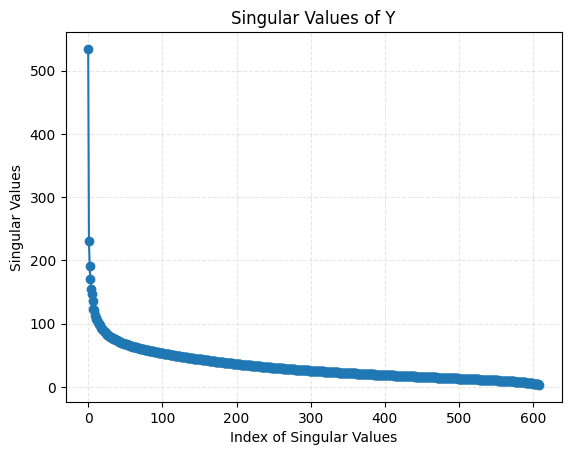

In [13]:
# compute the maximal k that is feasible for the function
k = min(Y.shape[0], Y.shape[1]) -1

# compute the singular values for sparse matrices
u, sigma, v = svds(Y, k=k)


# plot the singular values accordingly
plt.plot(sigma[::-1], 'o-')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.xlabel('Index of Singular Values')
plt.ylabel('Singular Values')
plt.title('Singular Values of Y')
plt.show()

- The plotted curve of the resulting singular values decreases exponentially after approximately index 20.
- It thus shows that there are few singular values with a comparatively high value and very many with a comparatively low value.
- Consequently, the rank of matrix $Y^S$ must be low, because its high-dimensional structure can very be approximated by few relevant singular values.

# 2: Implementation of the algorithms
In this chapter, the three different optimization algorithms named above will be implemented. Beforehand, it is indicated that we work with the whole dataset, consisting of 610 rows (users) and 9724 columns (movies). In total, only 1.7% of the entries have actual ratings (values other than 0). It is used to choose parameters and evaluate the algorithms after they have been implemented.

To simplify the implementation, especially to check the stop criteria, and guarantee fair comparison, a function is defined beforehand, returning the relative error of two input matrices.



In [14]:
n_users = len(user_ids)
n_movies = len(movie_ids)

# Create mask S (1 where observed, 0 elsewhere)
S_coo = coo_matrix((np.ones(len(data)), (row_ind, col_ind)), shape=(n_users, n_movies))
S = csr_matrix(S_coo)


n_sub = n_users  #min(300, n_users)
m_sub = n_movies   #min(500, n_movies)

Ys = Y[:n_sub, :m_sub].toarray()  # Y^S as dense array
S_dense = S[:n_sub, :m_sub].toarray()  # Mask as dense array

print(f"Working with subset: {Ys.shape}")
print(f"Observed entries: {np.sum(S_dense)}")
print(f"Sparsity: {np.sum(S_dense) / (n_sub * m_sub) * 100:.2f}%")

Working with subset: (610, 9724)
Observed entries: 100836.0
Sparsity: 1.70%


In [15]:

def err(X, Y, S):
    """
    Compute relative error: ||X^S - Y^S||_F / ||Y^S||_F

    Parameters:
        X: Current estimate (dense array)
        Y: Observed matrix Y^S (dense array)
        S: Mask of observed entries (dense array, 1 where observed)
    """
    # Restrict X to observed entries
    Xs = X * S
    # Compute ||X^S - Y^S|| / ||Y^S||
    # NOTE: Y is already Y^S (zeros outside S), so we use it directly
    numerator = np.linalg.norm(Xs - Y, 'fro')
    denominator = np.linalg.norm(Y, 'fro')
    return numerator / denominator if denominator > 0 else float('inf')

print("Error function defined!")

Error function defined!


## 2.1: Singular Value Projection (SVP)

The code below shows the implementation of the SVP algorithm according to the given pseudocode. More information about the individual steps of the implementation are found as comments in the code.

In [16]:
def svp(S, Ys, r, eta=1.0, tol=0.01, max_iter=500, verbose=True):
    """
    Singular Value Projection (SVP) Algorithm

    Parameters:
        S: Mask of observed entries (dense array)
        Ys: Observed matrix Y^S (dense array)
        r: Target rank
        eta: Learning rate (step size)
        tol: Tolerance for stopping criterion
        max_iter: Maximum number of iterations
        verbose: Print progress

    Returns:
        X: Completed matrix
        errors: List of errors per iteration
        elapsed: Computation time
    """
    start_time = time.time()

    # initialise results
    X = np.zeros((Ys.shape[0], Ys.shape[1]))
    errors = []
    iteration = 0

    # first stop criterium
    while err(X, Ys, S) > tol and iteration < max_iter:
        # compute Xs by turning entries outside of S to 0
        Xs = X * S

        # compute X_{t+1/2} - gradient step
        Xsvd = X + eta * (Ys - Xs)

        # compute SVD for sparse matrices up to order r
        # Use scipy.sparse.linalg.svds for efficiency
        try:
            U, Sigma, Vt = svds(csr_matrix(Xsvd), k=r)
            # svds returns in ASCENDING order, so reverse
            idx = np.argsort(Sigma)[::-1]
            U = U[:, idx]
            Sigma = Sigma[idx]
            Vt = Vt[idx, :]
        except:
            # Fallback to full SVD if svds fails
            U, Sigma_full, Vt = np.linalg.svd(Xsvd, full_matrices=False)
            U = U[:, :r]
            Sigma = Sigma_full[:r]
            Vt = Vt[:r, :]

        # update X_t: X_{t+1} = U @ diag(Sigma) @ Vt
        #  Sigma is a 1D array, need np.diag() to make it a matrix!
        Xnew = U @ np.diag(Sigma) @ Vt

        # Track error
        current_error = err(Xnew, Ys, S)
        errors.append(current_error)

        if verbose and (iteration % 50 == 0 or iteration < 5):
            print(f"  Iter {iteration:4d}: error = {current_error:.6f}")

        # second stop criterium after computing Xnew
        if len(errors) > 1 and current_error > errors[-2]:
            if verbose:
                print(f"  Stopped at iter {iteration} (error increasing)")
            break  # Keep X (not Xnew) since Xnew is worse

        # make Xt+1 the next Xt for the next iteration
        X = Xnew
        iteration += 1

    elapsed = time.time() - start_time

    if verbose and iteration >= max_iter:
        print(f"  Reached max iterations ({max_iter})")
    elif verbose and err(X, Ys, S) <= tol:
        print(f"  Converged at iter {iteration} (error < tol)")

    # return X (the best one), not Xnew
    return X, errors, elapsed


## 2.2: Singular Value Thresholding (SVT)

The code below shows the implementation of the SVT algorithm according to the given pseudocode. More information about the individual steps of the implementation are found as comments in the code.

In [17]:
def soft_threshold(x, lamb):
    """
    Soft thresholding operator: S_λ(x) = sign(x) * max(|x| - λ, 0)
    Works element-wise on arrays.
    """
    return np.sign(x) * np.maximum(np.abs(x) - lamb, 0)


def svt(S, Ys, lamb, eta=1.0, tol=0.01, max_iter=500, verbose=True):
    """
    Singular Value Thresholding (SVT) Algorithm
    Parameters:
        S: Mask of observed entries (dense array)
        Ys: Observed matrix Y^S (dense array)
        lamb: Soft thresholding parameter λ (controls rank)
        eta: Learning rate (step size)
        tol: Tolerance for stopping criterion
        max_iter: Maximum number of iterations
        verbose: Print progress

    Returns:
        X: Completed matrix
        errors: List of errors per iteration
        ranks: List of effective ranks per iteration
        elapsed: Computation time
    """
    start_time = time.time()

    # initialise results
    X = np.zeros((Ys.shape[0], Ys.shape[1]))
    errors = []
    ranks = []
    iteration = 0

    # first stop criterium
    while err(X, Ys, S) > tol and iteration < max_iter:
        # compute Xs by turning entries outside of S to 0
        Xs = X * S

        # compute X_{t+1/2} - gradient step
        Xsvd = X + eta * (Ys - Xs)

        # compute FULL SVD (need all singular values for soft thresholding)
        U, Sigma, Vt = np.linalg.svd(Xsvd, full_matrices=False)

        # compute S_lambda of Sigma (soft thresholding on singular values)
        # Sigma is a 1D array of singular values
        Sigma_thresh = soft_threshold(Sigma, lamb)

        # Count non-zero singular values (effective rank)
        nnz = np.sum(Sigma_thresh > 1e-10)

        # Reconstruct with thresholded singular values
        # Only use non-zero singular values for efficiency
        if nnz > 0:
            Xnew = U[:, :nnz] @ np.diag(Sigma_thresh[:nnz]) @ Vt[:nnz, :]
        else:
            Xnew = np.zeros_like(X)

        # Track error and rank
        current_error = err(Xnew, Ys, S)
        errors.append(current_error)
        ranks.append(nnz)

        if verbose and (iteration % 50 == 0 or iteration < 5):
            print(f"  Iter {iteration:4d}: error = {current_error:.6f}, rank = {nnz}")

        # second stop criterium after computing Xnew
        if len(errors) > 1 and current_error > errors[-2]:
            if verbose:
                print(f"  Stopped at iter {iteration} (error increasing)")
            break

        # make Xt+1 the next Xt for the next iteration
        X = Xnew
        iteration += 1

    elapsed = time.time() - start_time

    if verbose and iteration >= max_iter:
        print(f"  Reached max iterations ({max_iter})")
    elif verbose and err(X, Ys, S) <= tol:
        print(f"  Converged at iter {iteration} (error < tol)")

    return X, errors, ranks, elapsed


## 2.3: ADMiRA algorithm

The code below shows the implementation of the ADMiRA algorithm according to the given pseudocode. More information about the individual steps of the implementation are found as comments in the code.

In [18]:
def admira(S, Ys, r, tol=0.01, max_iter=100, verbose=True):
    """
    ADMiRA (Atomic Decomposition for Minimum Rank Approximation) Algorithm

    Parameters:
        S: Mask of observed entries (dense array)
        Ys: Observed matrix Y^S (dense array)
        r: Target rank
        tol: Tolerance for stopping criterion
        max_iter: Maximum number of iterations
        verbose: Print progress

    Returns:
        X: Completed matrix
        errors: List of errors per iteration
        elapsed: Computation time
    """
    start_time = time.time()

    n, m = Ys.shape

    # Initialize X_0 = 0 and Psi_0 = empty
    X = np.zeros((n, m))

    # Psi stores the subspace (we track U and V bases)
    U_psi = np.zeros((n, 0))  # Column space
    V_psi = np.zeros((m, 0))  # Row space

    errors = []
    iteration = 0

    while err(X, Ys, S) > tol and iteration < max_iter:
        # Step 1: Compute residual Y^S - X^S
        Xs = X * S
        residual = Ys - Xs

        # Step 2: Get top 2r singular vectors of residual
        k = min(2 * r, min(n, m) - 1)
        try:
            U_res, Sigma_res, Vt_res = svds(csr_matrix(residual), k=k)
            # Sort by descending singular values
            idx = np.argsort(Sigma_res)[::-1]
            U_res = U_res[:, idx]
            Vt_res = Vt_res[idx, :]
        except:
            U_res, Sigma_res, Vt_res = np.linalg.svd(residual, full_matrices=False)
            U_res = U_res[:, :k]
            Vt_res = Vt_res[:k, :]

        # Step 3: Psi_{t+1/2} = Psi_t ∪ {new atoms}
        # Merge current basis with new singular vectors
        if U_psi.shape[1] > 0:
            U_merged = np.hstack([U_psi, U_res])
            V_merged = np.hstack([V_psi, Vt_res.T])
        else:
            U_merged = U_res
            V_merged = Vt_res.T

        # Orthonormalize
        U_orth, _ = np.linalg.qr(U_merged)
        V_orth, _ = np.linalg.qr(V_merged)

        # Step 4: X_{t+1/2} = argmin ||Y^S - X^S||^2 s.t. X in span(Psi_{t+1/2})
        # Project Y onto the subspace
        X_half = U_orth @ (U_orth.T @ Ys @ V_orth) @ V_orth.T

        # Step 5-6: Truncate to rank r
        U_new, Sigma_new, Vt_new = np.linalg.svd(X_half, full_matrices=False)
        U_new = U_new[:, :r]
        Sigma_new = Sigma_new[:r]
        Vt_new = Vt_new[:r, :]

        # Update Psi (atoms)
        U_psi = U_new
        V_psi = Vt_new.T

        # Reconstruct X_{t+1}
        Xnew = U_new @ np.diag(Sigma_new) @ Vt_new

        # Track error
        current_error = err(Xnew, Ys, S)
        errors.append(current_error)

        if verbose and (iteration % 10 == 0 or iteration < 5):
            print(f"  Iter {iteration:4d}: error = {current_error:.6f}, atoms = {U_psi.shape[1]}")

        # Stop if error increases
        if len(errors) > 1 and current_error > errors[-2] + 1e-6:
            if verbose:
                print(f"  Stopped at iter {iteration} (error increasing)")
            break

        X = Xnew
        iteration += 1

    elapsed = time.time() - start_time

    if verbose and iteration >= max_iter:
        print(f"  Reached max iterations ({max_iter})")
    elif verbose and err(X, Ys, S) <= tol:
        print(f"  Converged at iter {iteration} (error < tol)")

    return X, errors, elapsed



# 3: Evaluation of the algorithms

In this chapter, the algorithms are applied to the dataset to compare the relative error and computation time as final evaluation. Beforehand, parameters are carefully chosen out of a suggested grid. We start by running the SVP algorithm for different values of the rank.


In [14]:
# =================================================================
# SVP EXPERIMENTS
# =============================================================================
print("SVP EXPERIMENTS \n")

svp_results = {}
ranks_to_test = [5, 10, 20, 30]

for r in ranks_to_test:
    print(f"\n--- Rank r = {r} ---")
    X, errors, elapsed = svp(S_dense, Ys, r=r, eta=1.0, tol=1e-3, max_iter=200)
    svp_results[r] = {'errors': errors, 'time': elapsed, 'final_error': errors[-1]}
    print(f"Final: error = {errors[-1]:.6f}, iters = {len(errors)}, time = {elapsed:.2f}s")

SVP EXPERIMENTS 


--- Rank r = 5 ---
  Iter    0: error = 0.742799
  Iter    1: error = 0.647658
  Iter    2: error = 0.589400
  Iter    3: error = 0.548111
  Iter    4: error = 0.516533
  Iter   50: error = 0.256712
  Iter  100: error = 0.217399
  Iter  150: error = 0.203094
  Reached max iterations (200)
Final: error = 0.196208, iters = 200, time = 238.77s

--- Rank r = 10 ---
  Iter    0: error = 0.697897
  Iter    1: error = 0.597005
  Iter    2: error = 0.535880
  Iter    3: error = 0.492806
  Iter    4: error = 0.460024
  Iter   50: error = 0.210260
  Iter  100: error = 0.179838
  Iter  150: error = 0.169541
  Reached max iterations (200)
Final: error = 0.164388, iters = 200, time = 259.58s

--- Rank r = 20 ---
  Iter    0: error = 0.647653
  Iter    1: error = 0.543825
  Iter    2: error = 0.480484
  Iter    3: error = 0.436122
  Iter    4: error = 0.402655
  Iter   50: error = 0.160646
  Iter  100: error = 0.136436
  Iter  150: error = 0.127633
  Reached max iterations (200)
F

After the same number of iterations, the relative error is decreasing with increasing rank. At the same time, the computation time increases. Note that this method does not have a regularization as SVT has. This is why our results suggest to choose a higher rank, but we also risk overfitting that way.

Since we have the best results with rank equal to 30 and this also aligns approxiamtely with the singular value plot that is shown in question 1.3, we fix it in order to subsequently determine an appropriate learning rate $\eta$.

In [19]:
print("SVP EXPERIMENTS \n")

svp_results_eta = {}
etas  = [0.005, 0.05, 0.2, 0.6]

for e in etas:
    print(f"\n--- learning rate = {e} ---")
    X, errors, elapsed = svp(S_dense, Ys, r=30, eta=e, tol=1e-3, max_iter=200)
    svp_results_eta[e] = {'errors': errors, 'time': elapsed, 'final_error': errors[-1]}
    print(f"Final: error = {errors[-1]:.6f}, iters = {len(errors)}, time = {elapsed:.2f}s")

SVP EXPERIMENTS 


--- learning rate = 0.005 ---
  Iter    0: error = 0.997465
  Iter    1: error = 0.994942
  Iter    2: error = 0.992432
  Iter    3: error = 0.989935
  Iter    4: error = 0.987450
  Iter   50: error = 0.885623
  Iter  100: error = 0.798219
  Iter  150: error = 0.729306
  Reached max iterations (200)
Final: error = 0.675309, iters = 200, time = 498.51s

--- learning rate = 0.05 ---
  Iter    0: error = 0.974793
  Iter    1: error = 0.950853
  Iter    2: error = 0.928111
  Iter    3: error = 0.906502
  Iter    4: error = 0.885964
  Iter   50: error = 0.489971
  Iter  100: error = 0.373479
  Iter  150: error = 0.312315
  Reached max iterations (200)
Final: error = 0.273192, iters = 200, time = 464.29s

--- learning rate = 0.2 ---
  Iter    0: error = 0.901338
  Iter    1: error = 0.822303
  Iter    2: error = 0.758538
  Iter    3: error = 0.706607
  Iter    4: error = 0.663831
  Iter   50: error = 0.269566
  Iter  100: error = 0.191138
  Iter  150: error = 0.157328
  Re

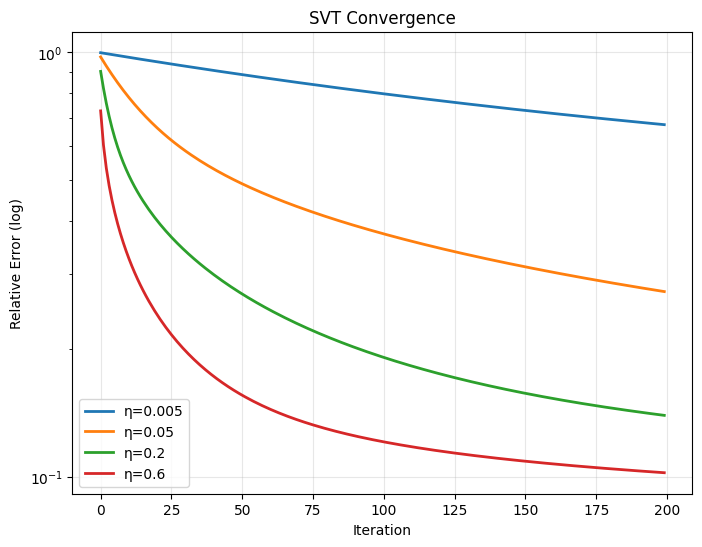

In [20]:
# plot the errors accordingly per learning rate
plt.figure(figsize=(8, 6))
for e in etas:
    plt.semilogy(svp_results_eta[e]['errors'], label=f'η={e}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log)')
plt.title('SVT Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The final resulting error is smaller with increasing value of $\eta$. The best result was actually reached with $\eta=1$, being conducted in the previous code block, when figuring out the most suitable rank with a final error of 0.0925 after 200 iterations with rank equal to 30. With the same rank, the resulting error is always above 0.1 with $\eta$ set to 0.6 or smaller. Maybe, this would have changed with more iterations, but due to the computation time that it takes, the maximal number of iterations is kept fixed at 200.

In [21]:
# =========================================================================
# SVT EXPERIMENTS
# =============================================================================
print("SVT EXPERIMENTS\n")


svt_results = {}
lambdas_to_test = [0.5, 1.0, 2.0, 5.0, 10.0]

for lamb in lambdas_to_test:
    print(f"\n--- Lambda = {lamb} ---")
    X, errors, ranks, elapsed = svt(S_dense, Ys, lamb=lamb, eta=1.0, tol=1e-3, max_iter=200)
    svt_results[lamb] = {
        'errors': errors,
        'ranks':ranks,
        'time': elapsed,
        'final_error': errors[-1],
        'final_rank': ranks[-1] if ranks else 0
    }
    print(f"Final: error = {errors[-1]:.6f}, rank = {ranks[-1]}, time = {elapsed:.2f}s")

SVT EXPERIMENTS


--- Lambda = 0.5 ---
  Iter    0: error = 0.009522, rank = 610
  Iter    1: error = 0.009533, rank = 610
  Stopped at iter 1 (error increasing)
Final: error = 0.009533, rank = 610, time = 8.30s

--- Lambda = 1.0 ---
  Iter    0: error = 0.019044, rank = 610
  Iter    1: error = 0.019088, rank = 610
  Stopped at iter 1 (error increasing)
Final: error = 0.019088, rank = 610, time = 5.55s

--- Lambda = 2.0 ---
  Iter    0: error = 0.038089, rank = 610
  Iter    1: error = 0.038259, rank = 608
  Stopped at iter 1 (error increasing)
Final: error = 0.038259, rank = 608, time = 8.26s

--- Lambda = 5.0 ---
  Iter    0: error = 0.095146, rank = 602
  Iter    1: error = 0.095653, rank = 585
  Stopped at iter 1 (error increasing)
Final: error = 0.095653, rank = 585, time = 5.51s

--- Lambda = 10.0 ---
  Iter    0: error = 0.188333, rank = 555
  Iter    1: error = 0.186107, rank = 496
  Iter    2: error = 0.183205, rank = 452
  Iter    3: error = 0.180640, rank = 417
  Iter    4:

Those results suggest to choose the regularization parameter $\lambda = 0.5$ for SVT, because it has the lowest resulting error. However, it breaks after the first iteration and suggests full rank. That is why you might also consider $\lambda = 10$, being the only value to actually have a decreasing error after the second iteration. The function ends up at a rank of 105.

In order to determine an appropriate learning rate, we will fix $\lambda=0.5$.

In [ ]:
print("SVT EXPERIMENTS \n")

svt_results_eta = {}
etas  = [0.05, 0.2, 0.6]

for e in etas:
    print(f"\n--- learning rate = {e} ---")
    X, errors, ranks, elapsed = svt(S_dense, Ys, lamb = 0.5, eta=e, tol=1e-3, max_iter=200)
    svt_results_eta[e] = {'errors': errors, 'time': elapsed, 'ranks': ranks, 'final_error': errors[-1]}
    print(f"Final: error = {errors[-1]:.6f}, rank = {ranks[-1]}, time = {elapsed:.2f}s")

SVT EXPERIMENTS 


--- learning rate = 0.05 ---
  Iter    0: error = 0.957611, rank = 555
  Iter    1: error = 0.917372, rank = 553
  Iter    2: error = 0.879176, rank = 552
  Iter    3: error = 0.842920, rank = 549
  Iter    4: error = 0.808510, rank = 548
  Iter   50: error = 0.234138, rank = 462
  Iter  100: error = 0.182608, rank = 386


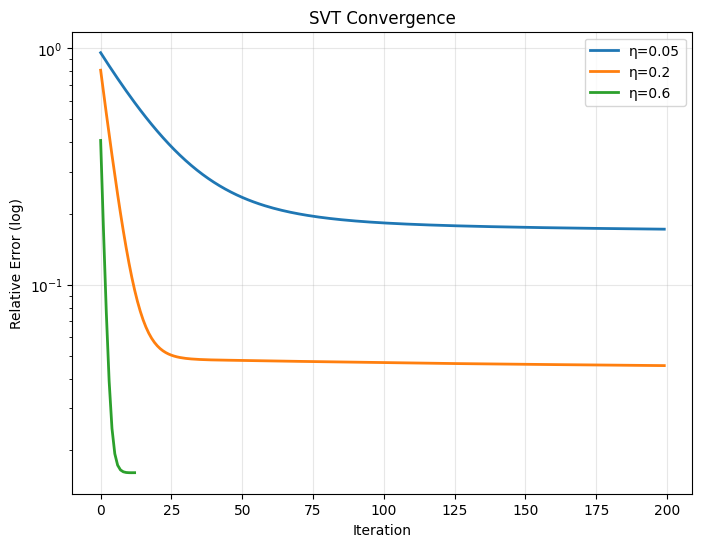

In [26]:
# plot the errors accordingly per learning rate
plt.figure(figsize=(8, 6))
for e in etas:
    plt.semilogy(svt_results_eta[e]['errors'], label=f'η={e}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log)')
plt.title('SVT Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The smallest error can be found at the setting of $\eta=1$ again, which has been conducted, when figuring out the best value for $\lambda$. However, the rank is not reduced in this case. This is why you might consider the setting with $\eta = 0.2$, where the rank could be reduced to ?? after 200 iterations and there is still a comparatively small resulting error of approximately ??.

In [ ]:
# =============================================================================
# ADMiRA EXPERIMENTS
# =========================================================================
print("ADMiRA EXPERIMENTS \n")

admira_results = {}
admira_ranks = [5, 10, 20]

for r in admira_ranks:
    print(f"\n--- Rank r = {r} -----")
    X, errors, elapsed = admira(S_dense, Ys, r=r, tol=1e-3, max_iter=50)
    admira_results[r] = {'errors': errors, 'time': elapsed, 'final_error': errors[-1]}
    print(f"Final: error = {errors[-1]:.6f}, iters = {len(errors)}, time = {elapsed:.2f}s")

ADMiRA EXPERIMENTS 


--- Rank r = 5 -----
  Iter    0: error = 0.742799, atoms = 5
  Iter    1: error = 0.742799, atoms = 5
  Iter    2: error = 0.742799, atoms = 5
  Iter    3: error = 0.742799, atoms = 5
  Iter    4: error = 0.742799, atoms = 5
  Iter   10: error = 0.742799, atoms = 5
  Iter   20: error = 0.742799, atoms = 5
  Iter   30: error = 0.742799, atoms = 5
  Iter   40: error = 0.742799, atoms = 5
  Reached max iterations (50)
Final: error = 0.742799, iters = 50, time = 86.76s

--- Rank r = 10 -----
  Iter    0: error = 0.697897, atoms = 10
  Iter    1: error = 0.697897, atoms = 10
  Iter    2: error = 0.697897, atoms = 10
  Iter    3: error = 0.697897, atoms = 10
  Iter    4: error = 0.697897, atoms = 10
  Iter   10: error = 0.697897, atoms = 10
  Iter   20: error = 0.697897, atoms = 10
  Iter   30: error = 0.697897, atoms = 10
  Iter   40: error = 0.697897, atoms = 10
  Reached max iterations (50)
Final: error = 0.697897, iters = 50, time = 63.02s

--- Rank r = 20 -----
  

With increasing rank, the computation time increases and the error decreases again. Thus, the ADMiRA algorithm shows best results for rank r=20.

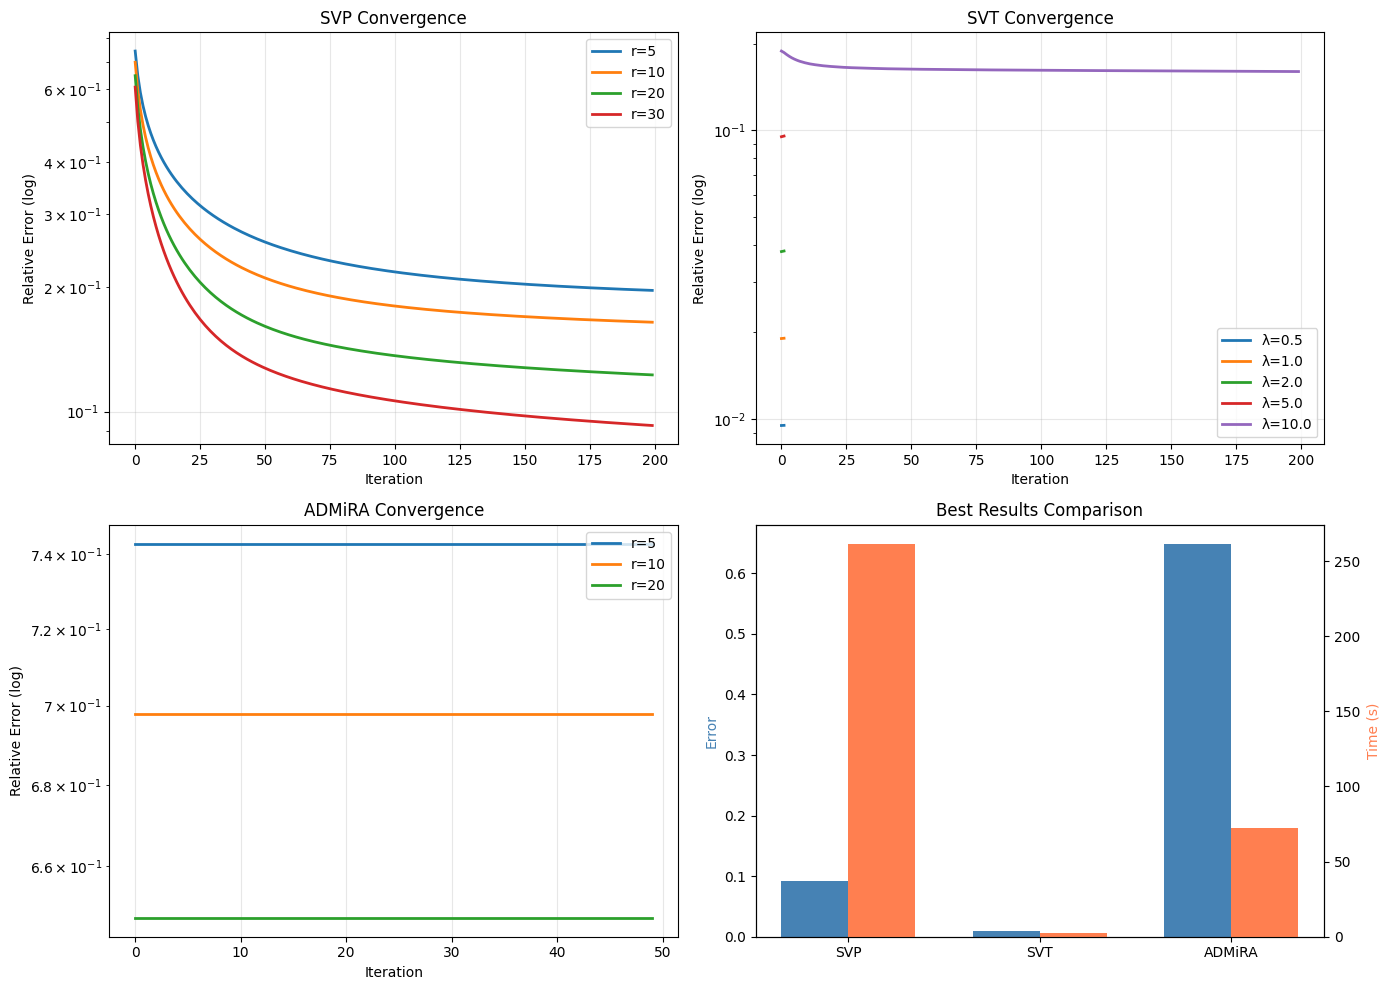

In [ ]:
# =============================================================================
# VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: SVP convergence
ax = axes[0, 0]
for r in ranks_to_test:
    ax.semilogy(svp_results[r]['errors'], label=f'r={r}', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Error (log)')
ax.set_title('SVP Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: SVT convergence
ax = axes[0, 1]
for lamb in lambdas_to_test:
    ax.semilogy(svt_results[lamb]['errors'], label=f'λ={lamb}', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Error (log)')
ax.set_title('SVT Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: ADMiRA convergence
ax = axes[1, 0]
for r in admira_ranks:
    ax.semilogy(admira_results[r]['errors'], label=f'r={r}', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Error (log)')
ax.set_title('ADMiRA Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Comparison
ax = axes[1, 1]
best_svp = min(svp_results.values(), key=lambda x: x['final_error'])
best_svt = min(svt_results.values(), key=lambda x: x['final_error'])
best_admira = min(admira_results.values(), key=lambda x: x['final_error'])

names = ['SVP', 'SVT', 'ADMiRA']
errors = [best_svp['final_error'], best_svt['final_error'], best_admira['final_error']]
times = [best_svp['time'], best_svt['time'], best_admira['time']]

x = np.arange(len(names))
width = 0.35
ax.bar(x - width/2, errors, width, label='Error', color='steelblue')
ax2 = ax.twinx()
ax2.bar(x + width/2, times, width, label='Time (s)', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylabel('Error', color='steelblue')
ax2.set_ylabel('Time (s)', color='coral')
ax.set_title('Best Results Comparison')

plt.tight_layout()
plt.show()

Above, you can see the previous results visualised.
- It espeacially makes clear that the error and needed time of the SVT algorithm perform by far the best.
- It also shows how the different algorithms converge: While SVP shows almost the same behavior for every rank, just shifted in terms of the value, only one parameter setting actually converges for the SVT algorithm.
- Concerning ADMIRA, the errors remain stable for over the iterations for every parameter setting, respectively.

In [ ]:
# =============================================================================
# SUMMARY TABLE
# =============================

print("\n-------SUMMARY-------\n")


print("\nSVP Results:")
print(f"{'Rank'} | {'Error'} | {'Iterations':} | {'Time (s)'}")
print("-" * 50)

for r in ranks_to_test:
    res = svp_results[r]
    print(f"{r} | {res['final_error']} | {len(res['errors'])} | {res['time']}")

print("\nSVT Results:")

print(f"{'Lambda'} | {'Error'} | {'Rank'} | {'Time (s)'}")


print("-" * 50)
for lamb in lambdas_to_test:
    res = svt_results[lamb]
    print(f"{lamb} | {res['final_error']} | {res['final_rank']} | {res['time']}")

print("\nADMiRA Results:")
print(f"{'Rank'} | {'Error'} | {'Iterations'} | {'Time (s)'}")

print("-" * 50)
for r in admira_ranks:
    res = admira_results[r]
    print(f"{r:>6} | {res['final_error']} | {len(res['errors'])} | {res['time']}")



print("\n" + "="*70)
print("BEST RESULTS")
print("="*70)
print(f"SVP:  {best_svp['final_error']} in {best_svp['time']}s")
print(f"SVT: {best_svt['final_error']} in {best_svt['time']}s")
print(f"ADMiRA: {best_admira['final_error']} in {best_admira['time']}s")


-------SUMMARY-------


SVP Results:
Rank | Error | Iterations | Time (s)
--------------------------------------------------
5 | 0.19620843558419546 | 200 | 173.06590270996094
10 | 0.16438811352669172 | 200 | 183.30156540870667
20 | 0.12263684366789651 | 200 | 221.35437321662903
30 | 0.09254868974226362 | 200 | 261.1248528957367

SVT Results:
Lambda | Error | Rank | Time (s)
--------------------------------------------------
0.5 | 0.009533107433185983 | 610 | 2.4016740322113037
1.0 | 0.01908846349208173 | 610 | 2.2637972831726074
2.0 | 0.038259382334904224 | 608 | 2.390247106552124
5.0 | 0.09565260900849264 | 585 | 2.401719808578491
10.0 | 0.1599511827881354 | 105 | 211.5099277496338

ADMiRA Results:
Rank | Error | Iterations | Time (s)
--------------------------------------------------
     5 | 0.7427992014095839 | 50 | 86.75654244422913
    10 | 0.6978968494064309 | 50 | 63.021360874176025
    20 | 0.6476534982025791 | 50 | 72.16005063056946

BEST RESULTS
SVP:  0.09254868974226362 i

### Final Recommendations for Movie Rating Prediction

1. **Start with SVT** for automatic rank selection and to prevent overfitting. Use cross-validation to tune λ.
2. **Use SVP** when domain knowledge suggests an approximate rank (typically 10-50 for movie ratings).
3. **Consider ADMiRA** for very large-scale problems where memory is a constraint.